In [2]:
import sys
import os
import matplotlib.pyplot as plt
import cv2

import numpy as np

# Add the src directory to the path. TEMPORARY FIX
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from src.data_processing.dataset_loader import CoastData
from src.data_processing.dataset_preprocessor import DatasetPreprocessor

In [3]:
data_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/processed_4_classes/"))

data = {}
filtered_data = {}
sation_names = ["agrelo", "arenaldentem", "cadiz", "cies", "samarador",]

for station in sation_names:
    data[station] = CoastData(data_path, name=station)
    filtered_data[station] = data[station].get_images_and_masks()
    filtered_data[station] = data[station].split_data()

    print("Train images:", len(filtered_data[station]['train']['images']))

    path_img = filtered_data[station]['train']['images'][0]
    path_mask = filtered_data[station]['train']['masks'][0]

    img = cv2.imread(path_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(path_mask, cv2.IMREAD_GRAYSCALE)

    print("Image shape:", img.shape)
    print("Mask shape:", mask.shape)
    print()

CoastData: agrelo - 244 images
Coast: agrelo, Total size: 244
Train images: 170
Image shape: (408, 761, 3)
Mask shape: (408, 761)

CoastData: arenaldentem - 40 images
Coast: arenaldentem, Total size: 40
Train images: 28
Image shape: (333, 797, 3)
Mask shape: (333, 797)

CoastData: cadiz - 946 images
Coast: cadiz, Total size: 946
Train images: 662
Image shape: (670, 801, 3)
Mask shape: (670, 801)

CoastData: cies - 430 images
Coast: cies, Total size: 430
Train images: 301
Image shape: (193, 376, 3)
Mask shape: (193, 376)

CoastData: samarador - 57 images
Coast: samarador, Total size: 57
Train images: 39
Image shape: (199, 236, 3)
Mask shape: (199, 236)



In [4]:
CLASS_COLORS = {
    'NoData': (0, 0, 0),        # (black)
    'Landwards': (139, 69, 19), # (brown)
    'Seawards': (0, 0, 255),    # (blue)
    'Shoreline': (0, 255, 0)    # (green)
}

# Define a custom colormap for the mask
def apply_custom_colormap(mask):
    # Create an RGB image initialized to black
    colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)

    # Assign colors based on class values
    colored_mask[mask == 0] = CLASS_COLORS["NoData"]
    colored_mask[mask == 2] = CLASS_COLORS["Seawards"]
    colored_mask[mask == 1] = CLASS_COLORS["Landwards"]
    colored_mask[mask == 3] = CLASS_COLORS["Shoreline"]

    return colored_mask

def crop_center(image, crop_size, start):
    """
    Crops the center of the image to the specified size.

    Parameters:
    image (np.array): The input image.
    crop_size (tuple): The desired crop size (width, height).

    Returns:
    np.array: The cropped image.
    """
    h, w = image.shape[:2]
    crop_w, crop_h = crop_size
    start_x, start_y = start

    end_x = start_x + crop_w
    end_y = start_y + crop_h

    return image[start_y:end_y, start_x:end_x]

config = {
    "agrelo": {
        "start": [230, 100],
    }, 
    "arenaldentem": {
        "start": [40, 0],
    },
    "cadiz": {
        "start": [70, 0],
    },
    "cies": {
        "start": [50, 0],
    },
    "samarador": {
        "start": [0, 0],
    }
}    

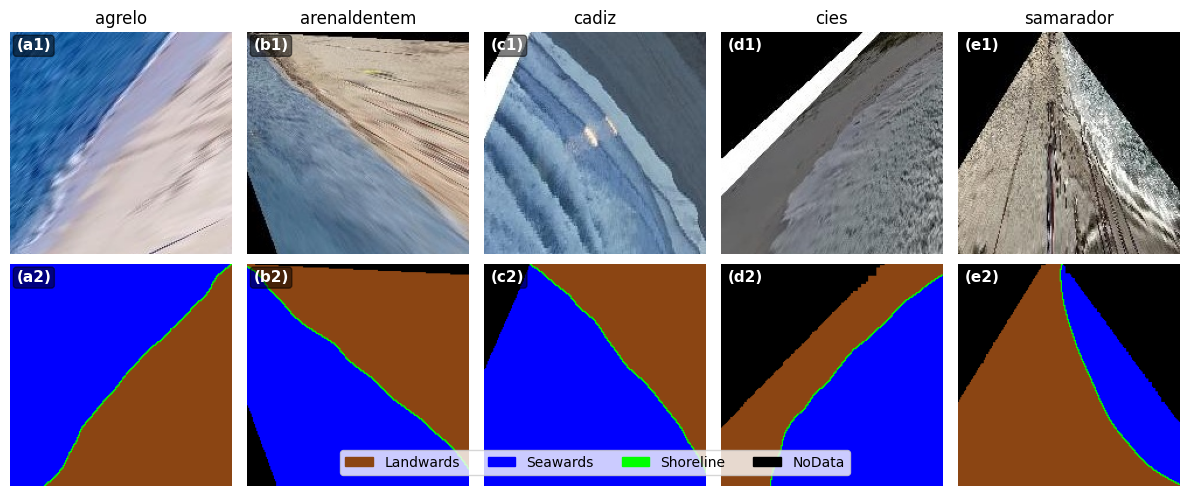

In [5]:

import matplotlib.patches as mpatches

# Replace this with your actual station list and data structure
station_names = list(config.keys())
labels = ['(a1)', '(b1)', '(c1)', '(d1)', '(e1)', '(a2)', '(b2)', '(c2)', '(d2)', '(e2)']

# Define the crop size (width x height)
crop_size = (190, 190)  # Width x Height

# Create the figure
fig, axes = plt.subplots(2, len(station_names), figsize=(12, 5.1))  # Slightly wider

# Loop over stations
for i, station in enumerate(station_names):
    # Read image
    path_img = filtered_data[station]['train']['images'][0]
    img = cv2.imread(path_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Read mask
    path_mask = filtered_data[station]['train']['masks'][0]
    mask = cv2.imread(path_mask, cv2.IMREAD_GRAYSCALE)

    # Crop image and mask
    img_crop = crop_center(img, crop_size, config[station]['start'])
    mask_crop = crop_center(mask, crop_size, config[station]['start'])

    # Apply color to mask
    colored_mask = apply_custom_colormap(mask_crop)

    # Top row: RGB image
    axes[0, i].imshow(img_crop)
    axes[0, i].axis('off')
    axes[0, i].set_title(station)

    # Bottom row: mask
    axes[1, i].imshow(colored_mask)
    axes[1, i].axis('off')

    # Add text labels
    axes[0, i].text(5, 15, labels[i], fontsize=11, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))
    axes[1, i].text(5, 15, labels[i+5], fontsize=11, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))

axes[0, 0].set_ylabel("Image", fontsize=12, rotation=90, labelpad=10, weight='bold', va='center')
axes[1, 0].set_ylabel("Mask", fontsize=12, rotation=90, labelpad=10, weight='bold', va='center')

# Add color legend below the figure
legend_patches = [
    mpatches.Patch(color=np.array(CLASS_COLORS['Landwards'])/255, label='Landwards'),
    mpatches.Patch(color=np.array(CLASS_COLORS['Seawards'])/255, label='Seawards'),
    mpatches.Patch(color=np.array(CLASS_COLORS['Shoreline'])/255, label='Shoreline'),
    mpatches.Patch(color=np.array(CLASS_COLORS['NoData'])/255, label='NoData'),
]
fig.legend(handles=legend_patches, loc='lower center', ncol=4, bbox_to_anchor=(0.5, +0.05))

# Layout
plt.tight_layout()
plt.show()

# Save the figure
fig.savefig(os.path.join("img", "example_images_and_masks.png"), bbox_inches='tight', dpi=300)

## Compute the percentage of pixels of each label

In [ ]:
# Compute the percentage of pixels of each label

for station in sation_names:
    # Create a dictionary to store the percentages for each label
    labels_percentages = {label: 0 for label in CLASS_COLORS.keys()}
    total_pixels = 0
    number_of_images = 0
    for split in ['train', 'validation', 'test']:
        images = filtered_data[station][split]['images']
        masks = filtered_data[station][split]['masks']

        # print(f"Station: {station}, Split: {split}, Number of images: {len(images)}")
        number_of_images += len(images)

        for i in range(len(images)):
            # img_path = images[i]
            mask_path = masks[i]

            # Read the mask
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Calculate the percentage of pixels for each label
            total_pixels += mask.size
            labels_percentages['NoData'] += np.sum(mask == 0)
            labels_percentages['Landwards'] += np.sum(mask == 1)
            labels_percentages['Seawards'] += np.sum(mask == 2)
            labels_percentages['Shoreline'] += np.sum(mask == 3)

    print(f"Station: {station}, Split: {split}, Number of images: {number_of_images}, Percentages:")
    for label, count in labels_percentages.items():
        percentage = (count / total_pixels) * 100
        print(f"  {label}: {percentage:.4f}%")

Station: agrelo, Split: test, Number of images: 244, Percentages:
  NoData: 18.2250%
  Landwards: 57.0168%
  Seawards: 24.4946%
  Shoreline: 0.2636%
Station: arenaldentem, Split: test, Number of images: 40, Percentages:
  NoData: 14.6943%
  Landwards: 62.7764%
  Seawards: 22.2593%
  Shoreline: 0.2699%
Station: cadiz, Split: test, Number of images: 946, Percentages:
  NoData: 28.6547%
  Landwards: 33.6473%
  Seawards: 37.5134%
  Shoreline: 0.1846%
Station: cies, Split: test, Number of images: 430, Percentages:
  NoData: 32.3825%
  Landwards: 21.3999%
  Seawards: 45.7550%
  Shoreline: 0.4625%
Station: samarador, Split: test, Number of images: 57, Percentages:
  NoData: 38.4485%
  Landwards: 42.0613%
  Seawards: 18.7701%
  Shoreline: 0.7200%
